In [1]:
# system tools
import os
import sys
sys.path.append(os.path.join(".."))

# pandas, numpy, gensim
import pandas as pd
import numpy as np
import gensim.downloader

# import my classifier utility functions - see the Github repo!
import utils.classifier_utils as clf

# Machine learning stuff
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics

# tools from tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Embedding, 
                                     Flatten, GlobalMaxPool1D, Conv1D)
from tensorflow.keras.optimizers import SGD, Adam #Adam = optimerings algoritme
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import L2

# matplotlib
import matplotlib.pyplot as plt

In [2]:
def plot_history(H, epochs):
    
# Utility function for plotting model history using matplotlib
    
# H: model history 
# epochs: number of epochs for which the model was trained

    plt.style.use("fivethirtyeight")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [3]:
def create_embedding_matrix(filepath, word_index, embedding_dim):

#    A helper function to read in saved GloVe embeddings and create an embedding matrix
    
#    filepath: path to GloVe embedding
#    word_index: indices from keras Tokenizer
#    embedding_dim: dimensions of keras embedding layer
    
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [4]:
def main():
    
    
    #Deffining filepath
    filepath = "Homework/Assignment6/Data/Game_of_Thrones_Script.csv"
    
    #Reading csv file as data frame.
    dataframe = pd.read_csv(filepath)
    
    #Creating np arrays based on the dataframe with the sentence, season and names data.
    sentences = dataframe["Sentence"].values
    seasons = dataframe["Season"].values
    names = dataframe["Name"].values
    
    #Creating test and training data
    X_train, X_test, y_train, y_test = train_test_split(sentences,
                                                        seasons,
                                                        test_size=0.25,
                                                        random_state=42)
    
    
    vectorizer = CountVectorizer()
    
    # First we do it for our training data...
    X_train_feats = vectorizer.fit_transform(X_train)
    #... then we do it for our test data
    X_test_feats = vectorizer.transform(X_test)
    # We can also create a list of the feature names. 
    feature_names = vectorizer.get_feature_names()
    
    y_train = pd.factorize(y_train)[0]
    y_test = pd.factorize(y_test)[0]
    
    l2 = L2(0.0001)
    
    # initialize tokenizer
    tokenizer = Tokenizer(num_words=5000) #vocabulary på 5000 ord
    # fit to training data
    tokenizer.fit_on_texts(X_train)

    # tokenized training and test data
    X_train_toks = tokenizer.texts_to_sequences(X_train) #konverter til sequences
    X_test_toks = tokenizer.texts_to_sequences(X_test)

    # overall vocabulary size
    vocab_size = len(tokenizer.word_index) + 1

    # inspect
    print(X_train[2])
    print(X_train_toks[2])
    #Dette er ikke en count representation, men er basseret på index.
    
    # define embedding size we want to work with
    embedding_dim = 50
    
    embedding_matrix = create_embedding_matrix("data/glove.6B.50d.txt",
                                               tokenizer.word_index, 
                                               embedding_dim)
    # max length for a doc
    maxlen = 100

    # pad training data to maxlen
    X_train_pad = pad_sequences(X_train_toks, 
                                padding="post", # sequences can be padded "pre" or "post"
                                maxlen=maxlen)
    # pad testing data to maxlen
    X_test_pad = pad_sequences(X_test_toks, 
                               padding="post", 
                               maxlen=maxlen)
    
    # New model
    model = Sequential()

    # Embedding -> CONV+ReLU -> MaxPool -> FC+ReLU -> Out
    model.add(Embedding(vocab_size,                  # vocab size from Tokenizer()
                        embedding_dim,               # embedding input layer size
                        weights=[embedding_matrix],  # pretrained embeddings
                        input_length=maxlen,         # maxlen of padded doc
                        trainable=True))             # trainable embeddings
    model.add(Conv1D(128, 5, 
                    activation="relu",
                    kernel_regularizer=l2))          # L2 regularization 
    model.add(GlobalMaxPool1D())
    model.add(Dense(10, activation="relu", kernel_regularizer=l2))
    model.add(Dense(1, activation="softmax"))

    # compile
    model.compile(loss="categorical_crossentropy", #Changing this from "binary_crossentropy" to "categorical_crossentropy", because we have more than two types of data (8 seasons.)
                  optimizer="adam",
                  metrics=["accuracy"])

    # print summary
    model.summary()
    
    
    history = model.fit(X_train_pad, y_train,
                        epochs=20,
                        verbose=False,
                        validation_data=(X_test_pad, y_test),
                        batch_size=10)

    # evaluate 
    loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))

    # plot
    plot_history(history, epochs = 20)
    plt.savefig("Homework/Assignment6/Output/training_loss.png")

Many will die no matter what we do. Better them than us.
[130, 27, 139, 25, 330, 20, 18, 22, 157, 40, 96, 54]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           448200    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           32128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 481,629
Trainable params: 481,629
Non-trainable params: 0
_________________________________________________________________
Traini

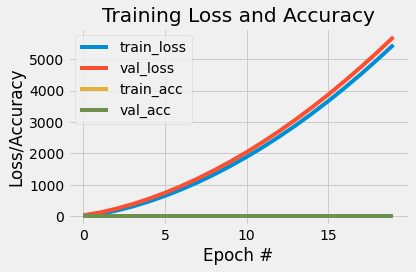

<Figure size 432x288 with 0 Axes>

In [5]:
if __name__ =="__main__":
    main()